In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from itertools import product

# preprocessing
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# handling detection
from sklearn.ensemble import IsolationForest

# imbalanced data 
from imblearn.over_sampling import SMOTE, SMOTENC

# models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# hyper-parameter tunning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer


# evaluation
from sklearn.metrics import\
    accuracy_score, confusion_matrix, classification_report, \
    f1_score, recall_score, balanced_accuracy_score, precision_score, \
    confusion_matrix, ConfusionMatrixDisplay


# storing the best model
import pickle


/Users/artmissg/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_columns', 30)  # Adjust the number as needed

%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

> notes :  
    - ❌ convert N_Days to 3 groups based on if there status, for example if the patient has died or ... 
    - ✅ convert Age from days to years ?
    -    the target labels, you actually divide them into two main groups, Survived / Dead . because groups CL and C represent survived people
    -    add additional features based on the notebook on kaggle
    -    new features based on whether the patient is in the normal range of a feature or not
    - ✅ use the more complete dataset

- outliers
    - you can still work on `Bilirubin` 
    
    
>  the given data is already preprocessed and the missing values are filled with the average of others

C  -> alive at N days  
CL -> alive at N days due to liver transplant  
D  -> dead at N days  

# Preprocessing

In [3]:
from src.pipelines import basic_pipeline

train_data = pd.read_csv("../data/train.csv").drop(columns=["id"])
train_data2 = pd.read_csv("../data/Cir.csv").drop(columns=["ID"]) # original data
data = pd.concat(objs=[train_data, train_data2]).reset_index(drop=True)
data = basic_pipeline.fit_transform(data)

#### Missing Value Imputation

In [4]:
from src.pipelines import missing_value_imputation

data = missing_value_imputation(data)

#### outlier removal

In [5]:
outlier_list = ["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

def quantile_outlier_removal(column: pd.Series, q1=0.25, q2=0.75) :
    Q1 = column.quantile(q1)
    Q3 = column.quantile(q2)
    IQR = Q3 - Q1
    filtered_column = column[
        (column >= (Q1 - 1.5*IQR)) & (column <= (Q3 + 1.5*IQR))
    ] # changed > to >= , and > to >=
      # in this case, columns like 'adults' won't have any problem
    return filtered_column

data.loc[:, outlier_list] = data[outlier_list].apply(
      lambda feature: quantile_outlier_removal(feature),
).dropna()

after this there will be some Nan values which we should drop

In [6]:
data.dropna(inplace=True)

In [7]:
data

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug
0,2.736986,58.991781,1.0,0,0,0,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,2,1
1,7.052055,52.704110,0.0,0,0,0,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0,0
2,9.391781,37.608219,0.0,0,1,1,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,2,0
3,7.057534,50.575342,0.0,0,0,0,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0,0
4,2.158904,45.638356,0.0,0,1,0,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8208,3.158904,61.224658,0.0,0,1,0,N,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2.0,0,1
8209,2.723288,58.339726,0.0,0,0,0,N,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2.0,0,0
8210,2.572603,62.375342,0.0,0,0,0,N,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2.0,0,1
8211,2.298630,38.024658,0.0,0,0,0,N,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2.0,0,1


#### Imbalance Data

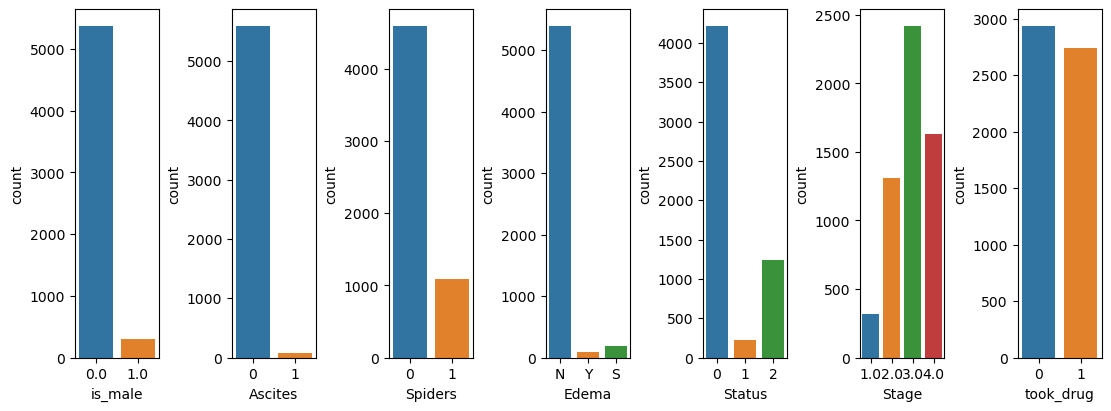

In [8]:
### categorical imbalanced data
imbalanced_list = ["is_male", "Ascites", "Spiders", "Edema", "Status", "Stage", "took_drug"]

fig, axes = plt.subplots(1, 7, figsize=(11, 4), layout="constrained")
for index, column in enumerate(imbalanced_list):
    sns.countplot(
        data,
        x=column,
        ax=axes[index],
    )
    

even our target variable `Status` is imbalanced

In [9]:
data

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug
0,2.736986,58.991781,1.0,0,0,0,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,2,1
1,7.052055,52.704110,0.0,0,0,0,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0,0
2,9.391781,37.608219,0.0,0,1,1,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,2,0
3,7.057534,50.575342,0.0,0,0,0,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0,0
4,2.158904,45.638356,0.0,0,1,0,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8208,3.158904,61.224658,0.0,0,1,0,N,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2.0,0,1
8209,2.723288,58.339726,0.0,0,0,0,N,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2.0,0,0
8210,2.572603,62.375342,0.0,0,0,0,N,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2.0,0,1
8211,2.298630,38.024658,0.0,0,0,0,N,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2.0,0,1


In [10]:
# using SMOTE for `Stage` and `Spiders` feature
categorical_features = ["is_male", "Hepatomegaly", "Spiders", "Edema", "Stage", "took_drug"]
sm = SMOTE(random_state=9090)
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=9090)
# smote_nc = SMOTE(random_state=9090)
X, y = smote_nc.fit_resample(data, data["Status"]) # ? should i drop `Status` ? does it cause data-leakage

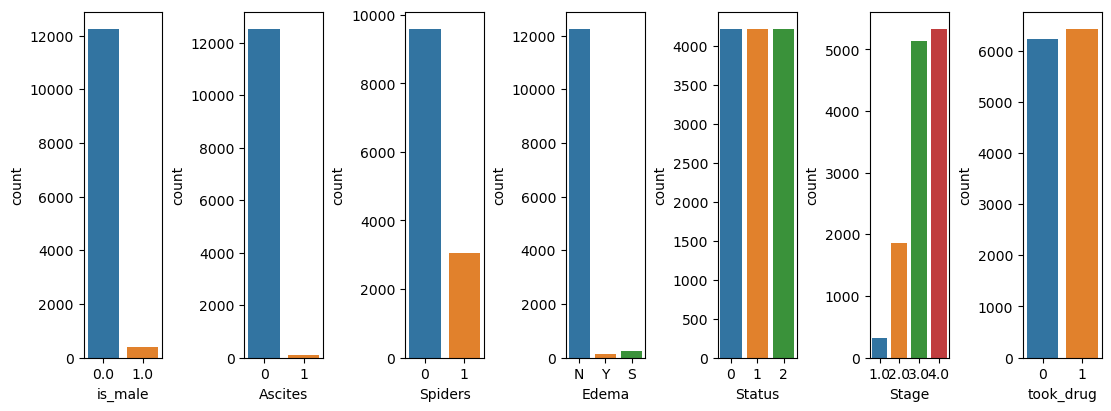

In [11]:
fig, axes = plt.subplots(1, 7, figsize=(11, 4), layout="constrained")
for index, column in enumerate(imbalanced_list):
    sns.countplot(
        X,
        x=column,
        ax=axes[index],
    )
    

it looked good so far

In [12]:
X

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug
0,2.736986,58.991781,1.0,0,0,0,N,2.300000,316.000000,3.350000,172.000000,1601.000000,179.800000,63.000000,394.000000,9.700000,3.0,2,1
1,7.052055,52.704110,0.0,0,0,0,N,0.900000,364.000000,3.540000,63.000000,1440.000000,134.850000,88.000000,361.000000,11.000000,3.0,0,0
2,9.391781,37.608219,0.0,0,1,1,Y,3.300000,299.000000,3.550000,131.000000,1029.000000,119.350000,50.000000,199.000000,11.700000,4.0,2,0
3,7.057534,50.575342,0.0,0,0,0,N,0.600000,256.000000,3.500000,58.000000,1653.000000,71.300000,96.000000,269.000000,10.700000,3.0,0,0
4,2.158904,45.638356,0.0,0,1,0,N,1.100000,346.000000,3.650000,63.000000,1181.000000,125.550000,96.000000,298.000000,10.600000,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12646,2.274149,60.840896,0.0,0,1,1,N,2.905185,394.131438,3.297450,158.250991,1820.828596,132.069302,133.932300,202.733161,11.156572,4.0,2,1
12647,6.008568,48.824212,0.0,0,1,0,N,3.478799,444.275612,3.614099,45.484101,2045.000000,89.900000,111.332158,225.000000,9.712014,4.0,2,1
12648,6.773519,51.713110,0.0,0,1,1,N,2.157310,261.895800,3.521765,123.416801,792.250402,91.434347,91.521001,179.905898,11.052100,4.0,2,0
12649,7.724548,56.803764,0.0,0,1,1,N,2.000000,267.000000,3.078395,89.000000,754.000000,195.286150,90.000000,140.565985,11.800000,4.0,2,0


In [13]:
new_data = X

___

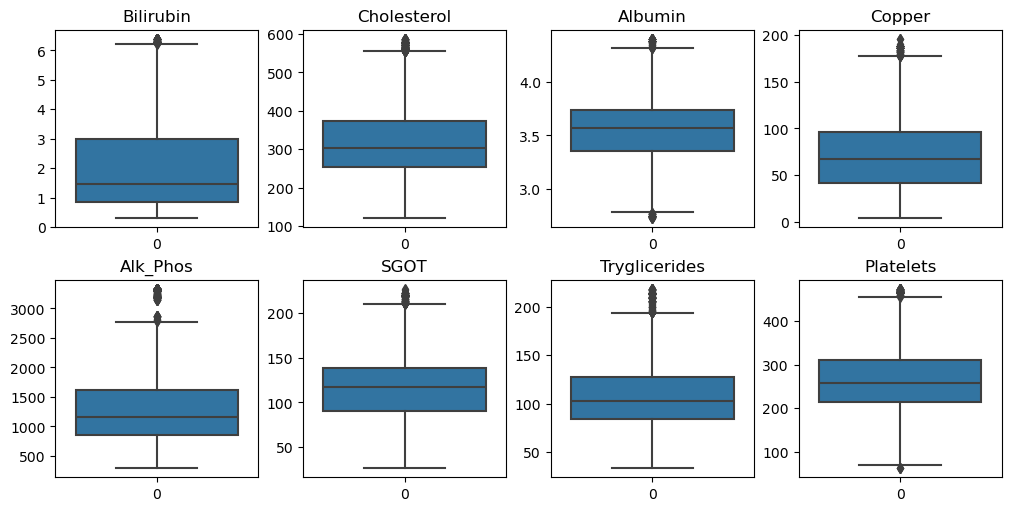

In [14]:
def box_plotter(df, features=None) :
    fig_x = 2
    fig_y = 4
    fig, axes = plt.subplots(fig_x, fig_y, figsize=(10, 5), layout="constrained")
    df = df.select_dtypes(["int", "float"]) if features==None else df.select_dtypes(["int", "float"])[features]
    for index, column in zip(product(range(fig_x), range(fig_y)), df) :
        sns.boxplot(
            df[column],
            ax=axes[index[0], index[1]],
        )
        axes[index[0], index[1]].set_title(column)
        
outlier_list = ["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]
box_plotter(new_data, outlier_list)

after using SMOTE, the data seems to have not much outliers!

#### Duplicate data

In [15]:
# Detect duplicate rows
duplicates = new_data.duplicated()
duplicates.sum()

88

In [16]:
new_data.drop_duplicates(inplace=True)

#### Encoding

we have done some of the encoding in `basic_pipeline`, only `Edema` is left  
for the time being, let's use `OneHotEncoding`

In [17]:
encoder = OneHotEncoder() 
new_values = encoder.fit_transform(new_data[["Edema"]])

In [18]:
encoder.get_feature_names_out()

array(['Edema_N', 'Edema_S', 'Edema_Y'], dtype=object)

In [19]:
new_values

<12563x3 sparse matrix of type '<class 'numpy.float64'>'
	with 12563 stored elements in Compressed Sparse Row format>

In [20]:
new_data[encoder.get_feature_names_out()] = new_values.toarray().astype('int8')

In [21]:
new_data.drop(columns=["Edema"], inplace=True)

# Modeling

In [22]:
# Bayesian search using skopt
np.int = np.int_ # fo fix the conflict with python version

opt = BayesSearchCV(
    xgb.XGBClassifier(),
    {
        "n_estimators": Integer(10, 100),
        "max_depth": Integer(5, 50),
        "num_class": Categorical([3]),
        "learning_rate": Real(0.01, 0.4, prior="uniform"),
        "booster": Categorical(["gbtree", "gblinear"]),
        "device": Categorical(["gpu"]),
        # "early_stopping_rounds": Categorical([0, 5, 10, 20]),
        "eval_metric":  ["logloss"], # ['mlogloss'],
    },
    n_iter=32,
    cv=5,
    scoring='accuracy',
    verbose=3,
    random_state=9090,
)

In [23]:
final_data = new_data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(final_data.drop(columns=["Status"]), final_data["Status"])

In [25]:
from src.pipelines import train_pipeline

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END booster=gblinear, device=gpu, eval_metric=logloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.612 total time=   0.1s
[CV 2/5] END booster=gblinear, device=gpu, eval_metric=logloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.602 total time=   0.0s
[CV 3/5] END booster=gblinear, device=gpu, eval_metric=logloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.578 total time=   0.0s
[CV 4/5] END booster=gblinear, device=gpu, eval_metric=logloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.610 total time=   0.0s
[CV 5/5] END booster=gblinear, device=gpu, eval_metric=logloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.636 total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5

In [26]:
opt.best_score_

0.9153052087381102

# Evaluation

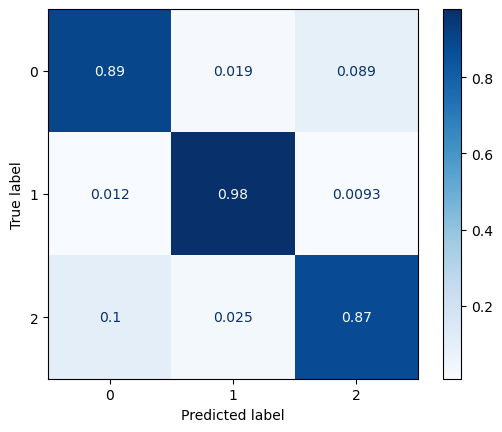

In [27]:
y_ = opt.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_, normalize='true', # display_labels=label_encoder.classes_
    cmap="Blues",
)
plt.show()

In [28]:
f1_score(
    y_test,
    y_,
    average="macro",
)

0.914543747898072

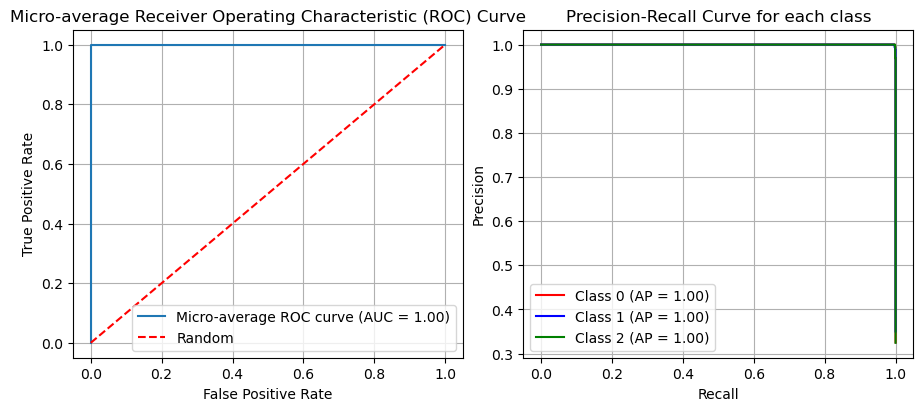

In [29]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Assuming y_true contains true labels and y_pred_probs contains predicted probabilities for each class

# Binarize the labels
y_true_bin = label_binarize(y_, classes=[0, 1, 2])  # Replace classes with your unique class labels
y_pred_probs = opt.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Replace num_classes with the number of unique classes
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute Precision-Recall curve and average precision score for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):  # Replace num_classes with the number of unique classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])

# Compute micro-average precision-recall curve and average precision score
precision_micro, recall_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_probs.ravel())
average_precision_micro = average_precision_score(y_true_bin, y_pred_probs, average='micro')

# Plot micro-average ROC curve
fig, axes = plt.subplots(1, 2, figsize=(9, 4), layout="constrained")
# axes[0].figure(figsize=(8, 6))
axes[0].plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})')
axes[0].plot([0, 1], [0, 1], 'r--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Micro-average Receiver Operating Characteristic (ROC) Curve')
axes[0].legend()
axes[0].grid()

# Plot Precision-Recall curve for each class
for i, color in zip(range(3), ["red", "blue", "green"]):
    axes[1].plot(recall[i], precision[i], color=color, label=f'Class {i} (AP = {average_precision[i]:.2f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve for each class')
axes[1].legend(loc='best')
axes[1].grid()


In [30]:
from sklearn.metrics import log_loss
log_loss(y_test, opt.predict_proba(X_test))

0.24298017224886642

# Submission

In [32]:
from src.pipelines import train_pipeline
import warnings

final_model = BayesSearchCV(
    xgb.XGBClassifier(),
    {
        "n_estimators": Integer(10, 100),
        "max_depth": Integer(5, 50),
        "num_class": Categorical([3]),
        "learning_rate": Real(0.01, 0.4, prior="uniform"),
        "booster": Categorical(["gbtree", "gblinear"]),
        "device": Categorical(["gpu"]),
        # "early_stopping_rounds": Categorical([0, 5, 10, 20]),
        "eval_metric": ['logloss'],
    },
    n_iter=32,
    cv=5,
    scoring='accuracy',
    verbose=3,
    random_state=9090,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    final_model.fit(final_data.drop(columns=["Status"]), final_data["Status"])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END booster=gblinear, device=gpu, eval_metric=logloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.596 total time=   0.1s
[CV 2/5] END booster=gblinear, device=gpu, eval_metric=logloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.598 total time=   0.0s
[CV 3/5] END booster=gblinear, device=gpu, eval_metric=logloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.584 total time=   0.0s
[CV 4/5] END booster=gblinear, device=gpu, eval_metric=logloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.610 total time=   0.0s
[CV 5/5] END booster=gblinear, device=gpu, eval_metric=logloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.612 total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5

In [36]:
final_model.best_score_

0.9191319786790221

In [37]:
from sklearn.metrics import log_loss
log_loss(final_data["Status"], final_model.predict_proba(final_data.drop(columns=["Status"])))

0.030990639112810157

In [38]:
data_test = pd.read_csv("../data/test.csv").drop(columns=["id"])
data_test = basic_pipeline.fit_transform(data_test)

# encode Edema
encoder = OneHotEncoder() 
new_values = encoder.fit_transform(data_test[["Edema"]])
data_test[encoder.get_feature_names_out()] = new_values.toarray().astype('int8')
data_test.drop(columns=["Edema"], inplace=True)

In [43]:
# predicting using the `model`
model = final_model

y_pred = model.predict_proba(data_test)
ans = pd.DataFrame(
    y_pred,
    columns=["Status_C", "Status_CL", "Status_D"]
)
# fixing the id column for the final answer
id_ = pd.read_csv("../data/test.csv")["id"]
ans.insert(0, column="id", value=id_)
ans.to_csv('ans.csv', index=False)